<a href="https://colab.research.google.com/github/FLC-ML/practicespace/blob/swimmer-practice-1/LSTM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Time Series Classification Using LSTM

This is a cleaned-up version of architecture used for the classification of Raman signals from bacterial isolates. 

# Load Data

The most direct way to download data is from the URL. Use `!wget` to download the files. For this Dropbox URL, make sure to change the "0" at the end to a "1" to force the download.

In [2]:
# Training Data
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AACaXFPq1qA5kLvhIF0Y0NfEa/y_reference.npy
# Testing Data
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AABKsseO9QvObI4lTt-yXg8ta/X_test.npy
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AACitgFQG5cfd7qs--swRbI0a/y_test.npy

--2020-07-20 21:02:29--  https://www.dropbox.com/sh/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy [following]
--2020-07-20 21:02:29--  https://www.dropbox.com/sh/raw/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8f4cd415c2cc93b98938fbe0c2.dl.dropboxusercontent.com/cd/0/inline/A77LkemCPpbTmzPWOwc6a4JryO-jhFrA5v0R19u_QEgHoc4HCqpyi7aZgb1v_5aDSan-5TeK_4zft8Ujk4hJQpxgELozg5uf2n3pCsmWvmITGfeIjf5S2x1OUwmbEGGvxZo/file# [following]
--2020-07-20 21:02:29--  https://uc8f4cd415c2cc93b98938fbe0c2.dl.dropboxusercontent.com/cd/0/inline/A77LkemCPpbTmzPWOwc6a

# Import Libraries

Adding in functions from libraries also makes the code easier to read. Tensorflow and Numpy are the main libraries. Matplotlib is used for data visualization, as well as sklearn for the confusion matrix.

In [3]:
# Importing libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Flatten, BatchNormalization, Dropout, Conv1D, GlobalMaxPool1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import confusion_matrix
import itertools

import numpy as np
import matplotlib.pyplot as plt # Use pip install to get this outside of notebook
from matplotlib import cm

# Load the data

Load the reference and test data into Numpy arrays. You will need to also reshape the data to feed into the model. Number of shapes needs to be 3.

In [4]:
# Training Data Load
X_train_loc = 'X_reference.npy'
y_train_loc = 'y_reference.npy'
X_train = np.load(X_train_loc)
y_train = np.load(y_train_loc)

# Testing data
X_test_loc = 'X_test.npy'
y_test_loc = 'y_test.npy'
X_test = np.load(X_test_loc)
y_test = np.load(y_test_loc)

Reshape the data with the code below.

In [5]:
# The data is only 2D in shape.
X_train = np.expand_dims(X_train, -1) 
X_test = np.expand_dims(X_test, -1)
print("\nnew x_train shape:", X_train.shape)
print("new x_test shape:", X_test.shape)
print("\nAll X data index shape:", X_train[0].shape)


new x_train shape: (60000, 1000, 1)
new x_test shape: (3000, 1000, 1)

All X data index shape: (1000, 1)


Showing the final shape of the loaded data.

In [6]:
# Print shape of data loaded.
print("training set shape:", X_train.shape, y_train.shape)
print("test set shape:", X_test.shape, y_test.shape)

training set shape: (60000, 1000, 1) (60000,)
test set shape: (3000, 1000, 1) (3000,)


# *Some Data Visualization

This section can be skipped as it is not necessary in getting results. However, it is worth showing how this data is represented. <br />
- X reference data is 60000 samples long, each containing 1000 data points ranging from 0 to 1. All data is normalized in this way. Each isolate has 2000 total spectra.
- X test data is 3000 samples long, with the same domain and range as the reference data. Each isolate has 100 total spectra.
- Y data is an array from 0 to 29, which are the labels for the 30 total bacterial isolates.


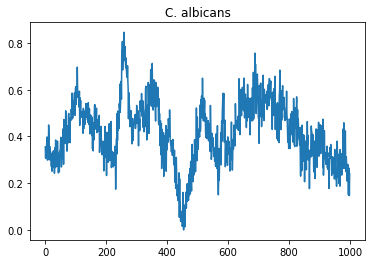

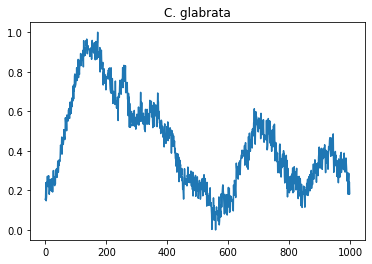

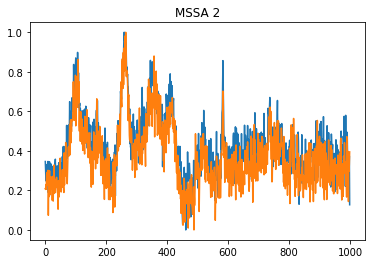

In [7]:
# Example Plots of Some Signals

# Plotting first label, C. albicans
plt.figure()
plt.title("C. albicans")
plt.plot(X_train[0])

# Plotting second label.
plt.figure()
plt.title("C. glabrata")
plt.plot(X_train[2000])
         
# Plotting two signals of MSSA 2
plt.figure()
plt.title("MSSA 2")
plt.plot(X_train[19000])
plt.plot(X_train[19005])

# Build the Model
- Shuffle the datasets.
- Create layers
- Summarize model
- Also info about Keras callbacks

(Add more explanation here)

In [51]:
# Learn how to use this callback.
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5)

In [9]:
# Shuffling the training data
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X = X_train[indices]
y = y_train[indices]

# Shuffling the testing data.
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
XX = X_test
yy = y_test


In [80]:
# Build the model
i = Input(shape=X[0].shape)
x = LSTM(100, return_sequences=True)(i)
x = BatchNormalization()(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(30, activation='softmax')(x)

model = Model(i, x)
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 1000, 1)]         0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 1000, 100)         40800     
_________________________________________________________________
batch_normalization_84 (Batc (None, 1000, 100)         400       
_________________________________________________________________
dropout_55 (Dropout)         (None, 1000, 100)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 100000)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 30)                3000030   
Total params: 3,041,230
Trainable params: 3,041,030
Non-trainable params: 200
______________________________________________

# Train the model

In [81]:
# Compile and train

# Timer for computation time.
from time import time
start = time()

# Compiled model and fitted code.
model.compile(optimizer=Adam(lr=.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(X, y, validation_data=(X_test, y_test), batch_size=1000, epochs=100,
              callbacks=early_stop)

# Printing computation time total in seconds.
print('\nTotal time of computation:', time() - start)

Epoch 1/100
60/60 [==============================] - 13s 223ms/step - loss: 2.1222 - accuracy: 0.6764 - val_loss: 3.1136 - val_accuracy: 0.2063
Epoch 2/100
60/60 [==============================] - 13s 221ms/step - loss: 0.2858 - accuracy: 0.9261 - val_loss: 2.8309 - val_accuracy: 0.2623
Epoch 3/100
60/60 [==============================] - 13s 220ms/step - loss: 0.1948 - accuracy: 0.9422 - val_loss: 2.5191 - val_accuracy: 0.3137
Epoch 4/100
60/60 [==============================] - 13s 221ms/step - loss: 0.1604 - accuracy: 0.9495 - val_loss: 2.2920 - val_accuracy: 0.3410
Epoch 5/100
60/60 [==============================] - 13s 224ms/step - loss: 0.1490 - accuracy: 0.9516 - val_loss: 2.1177 - val_accuracy: 0.3753
Epoch 6/100
60/60 [==============================] - 13s 223ms/step - loss: 0.1388 - accuracy: 0.9541 - val_loss: 1.9777 - val_accuracy: 0.4390
Epoch 7/100
60/60 [==============================] - 13s 224ms/step - loss: 0.1306 - accuracy: 0.9567 - val_loss: 1.8422 - val_accuracy:

# Evaluate the model

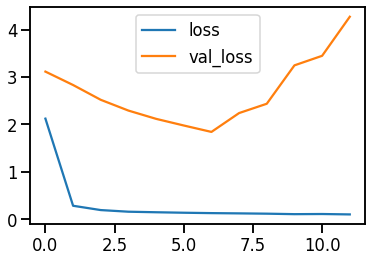

In [82]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

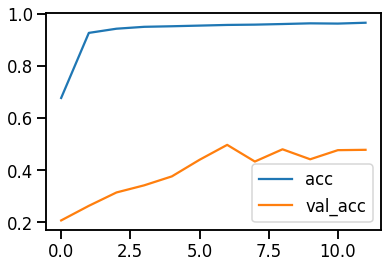

In [83]:
### Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [84]:
# Final evaluation of the model
scores = model.evaluate(XX, yy, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 47.73%


# Confusion Matrix

In [85]:
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [29]:
# 30 reference isolates
ORDER = [16, 17, 14, 18, 15, 20, 21, 24, 23, 26, 27, 28, 29, 25, 6, 7, 5, 3, 4,
         9, 10, 2, 8, 11, 22, 19, 12, 13, 0, 1]

STRAINS = {}
STRAINS[0] = "C. albicans"
STRAINS[1] = "C. glabrata"
STRAINS[2] = "K. aerogenes"
STRAINS[3] = "E. coli 1"
STRAINS[4] = "E. coli 2"
STRAINS[5] = "E. faecium"
STRAINS[6] = "E. faecalis 1"
STRAINS[7] = "E. faecalis 2"
STRAINS[8] = "E. cloacae"
STRAINS[9] = "K. pneumoniae 1"
STRAINS[10] = "K. pneumoniae 2"
STRAINS[11] = "P. mirabilis"
STRAINS[12] = "P. aeruginosa 1"
STRAINS[13] = "P. aeruginosa 2"
STRAINS[14] = "MSSA 1"
STRAINS[15] = "MSSA 3"
STRAINS[16] = "MRSA 1 (isogenic)"
STRAINS[17] = "MRSA 2"
STRAINS[18] = "MSSA 2"
STRAINS[19] = "S. enterica"
STRAINS[20] = "S. epidermidis"
STRAINS[21] = "S. lugdunensis"
STRAINS[22] = "S. marcescens"
STRAINS[23] = "S. pneumoniae 2"
STRAINS[24] = "S. pneumoniae 1"
STRAINS[25] = "S. sanguinis"
STRAINS[26] = "Group A Strep."
STRAINS[27] = "Group B Strep."
STRAINS[28] = "Group C Strep."
STRAINS[29] = "Group G Strep."

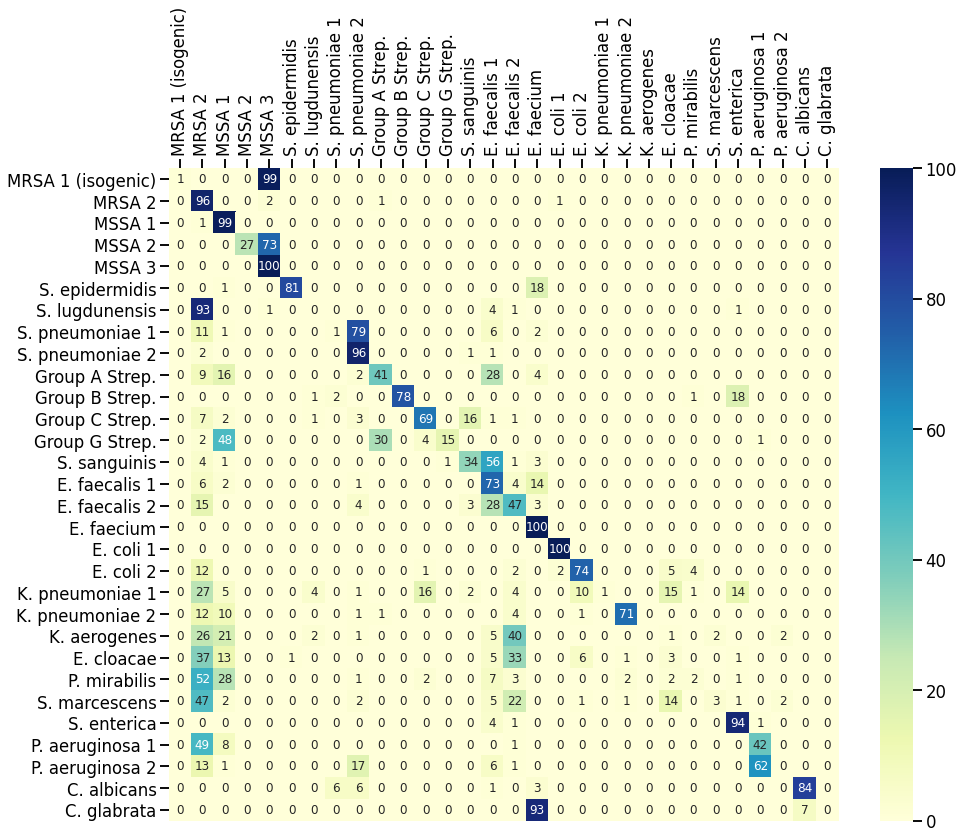

In [86]:
# Plot confusion matrix
p_test = model.predict(X_test).argmax(axis=1)

sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [STRAINS[i] for i in ORDER]
cm = confusion_matrix(y_test, p_test, labels=ORDER)
plt.figure(figsize=(15, 12))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

Misclassified Examples

In [40]:
# Label mapping
labels = '''C_albicans
C_glabrata
K_aerogenes
E_coli_1
E_coli_2
E_faecium
E_faecalis_1
E_faecalis_2
E_cloacae
K_pneumoniae_1
K_pneumoniae_2
P_mirabilis
P_aeruginosa_1
P_aeruginosa_2
MSSA_1
MSSA_3
MRSA_1
MRSA_2
MSSA_2
S_enterica
S_epidermidis
S_lugdenensis
S_marcescens
S_pneumoniae_2
S_pneumoniae_1
S_sanguinis
Group_A_Strep.
Group_B_Strep
Group_C_Strep
Group_G_Strep'''.split()

Total misclassifications: 1568
Index of misclassified example: 915


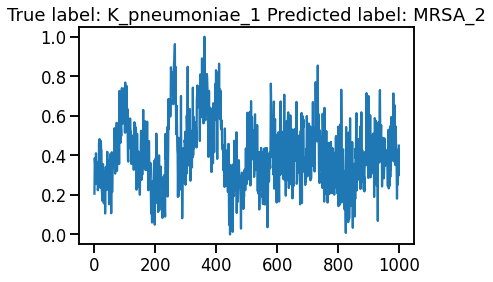

In [87]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
print('Total misclassifications:', len(misclassified_idx))
print('Index of misclassified example:',i)
#print(type(i))
# Changing float64 to int64
new_i = i.astype(int)
y_testnew = y_test.astype(int)
p_testnew = p_test.astype(int)
#print(type(new_i))
plt.plot(X_test[new_i])
plt.title("True label: %s Predicted label: %s" % (labels[y_testnew[new_i]], labels[p_testnew[new_i]]));